# Efficient Sinkhorn Algorithm Utilizing Toeplitz Matrices

-----

In [1]:
import mkl_fft
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.spatial.distance import cdist
from tqdm import tqdm

# Baseline Sinkhorn

In [2]:
def sinkhorn(X, Y, beta=0.01, max_iter=200, stop=True, eps=1e-12, tol=1e-10, patience=10, verbose=True, plot=True):
    '''
    X, Y - datapoint of two distributions
    beta - regularization parameter 
    '''
    n, m = len(X), len(Y)
    C = cdist(X, Y)
    
    p = np.ones(n) / n
    q = np.ones(m) / m
    
    K = np.exp(-C / beta)
    Kt = K.T
    b = np.ones(m)
    i = 0
    err = [10]
    j = 0
    while i < max_iter:
        Kb = K.dot(b)
        a = np.divide(p, Kb)
        Kta = Kt.dot(a)
        b = np.divide(q, Kta)
        if stop:
            g0 = a * K.dot(b)
            g1 = b * Kt.dot(a)
            err.append(np.linalg.norm(g0 - p) + np.linalg.norm(g1 - q))
            # if good enough
            if err[-1] < eps:
                if verbose:
                    print(f'#iterations={i+1}, early stopping: eps, err={err[-1]}')
                break
            # if no improvements
            if np.abs(err[-2] - err[-1]) < tol:
                j += 1
                if j > patience:
                    if verbose:
                        print(f'#iterations={i+1}, early stopping: tol, err={err[-1]}')
                    break
            else:
                j = 0
        i +=1
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('error')
        plt.semilogy(range(len(err)-1), err[1:])
        plt.subplot(122)
        plt.title('optimal transport matrix')
        plt.imshow(a.reshape(-1,1) * K * b.reshape(1,-1))
        plt.show()
    
    return K, a, b

# Binning distribution

In [3]:
centers = lambda edges: (edges[:,:-1] + edges[:,1:]) / 2

def binning(X, Y, bin_size):
    '''
    X, Y: nd.array,
            data points of two distributions
    bin_size: int,
            number of bins (equal for each dimension!)
    '''
    
    clouds = np.vstack([X, Y])
    
    grid = np.linspace(np.min(clouds, 0), np.max(clouds, 0), bin_size + 1).T # [D, B] n+m +b
    
    mesh = np.meshgrid(*centers(grid), indexing='xy') 
    bins = np.hstack([x.reshape(-1,1) for x in mesh])
    
    p, _ = np.histogramdd(X, bins=grid)
    q, _ = np.histogramdd(Y, bins=grid)
    p /= p.sum()
    q /= q.sum()
    
    return bins, p, q

In [4]:
from time import time
ttt = []
for _ in range(10):
    for b in [16, 64, 256, 1024, 32768]:
        for i in range(10, 10000, 100):
            t = time()
            _ = binning(np.random.rand(i, 1), np.random.rand(i, 1), b)
            ttt.append(time() - t)

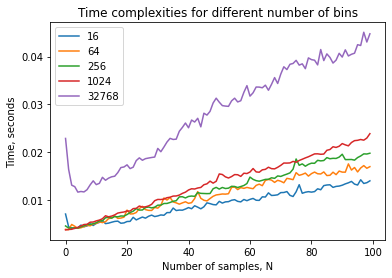

In [5]:
plt.plot(np.array(ttt).reshape(10, 5, -1).sum(0).T)
plt.title('Time complexities for different number of bins')
plt.legend(['16', '64', '256', '1024', '32768'])
plt.xlabel('Number of samples, N')
plt.ylabel('Time, seconds')
plt.show()

# 1D bins

In [6]:
X, Y = np.random.normal(-4, 2, (20, 1)), np.random.normal(4, 2, (30, 1))
n1d = 16

In [7]:
bins, p, q = binning(X, Y, n1d)

c = cdist(bins.reshape(-1,1), bins.reshape(-1,1))
c1d = c

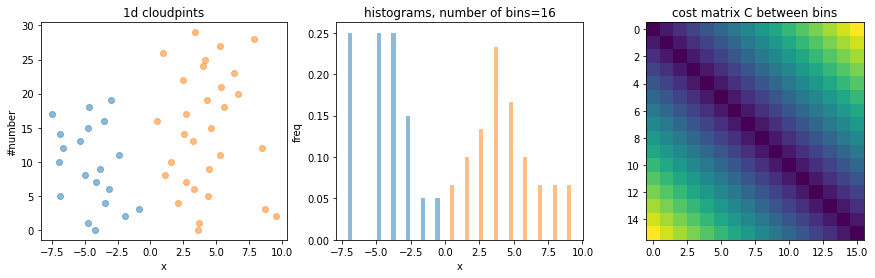

In [8]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('1d cloudpints')
plt.xlabel('x')
plt.ylabel('#number')
plt.scatter(X, range(len(X)), alpha=0.5)
plt.scatter(Y, range(len(Y)), alpha=0.5)
plt.subplot(132)
plt.title(f'histograms, number of bins={n1d}')
plt.xlabel('x')
plt.ylabel('freq')
plt.bar(bins.ravel(), p, width=0.3, alpha=0.5, label='p')
plt.bar(bins.ravel(), q, width=0.3, alpha=0.5, label='q')
plt.subplot(133)
plt.title('cost matrix C between bins')
plt.imshow(c)
plt.show()

#iterations=69, early stopping: tol, err=9.813077866773595e-18


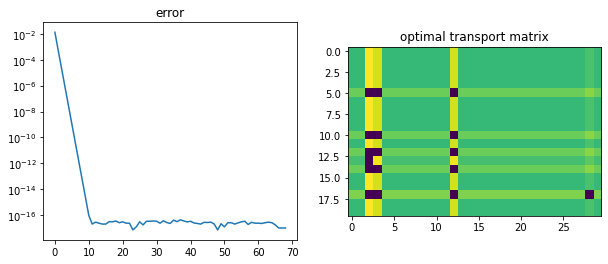

In [9]:
K, u, v = sinkhorn(X, Y, 0.02, max_iter=2000, eps=1e-20, tol=1e-17, patience=10)

In [10]:
save = dict(p=p, q=q, bins=bins, K=K, u=u, v=v, c=c)

# 2D bins

In [11]:
N, M, d = 20, 30, 2
X = np.random.normal(0, 3, (N, d))
Y = np.random.normal(10, 3, (M, d))

n2d = 8

In [12]:
bins, p, q = binning(X, Y, n2d)
c = cdist(bins, bins)
c2d = c

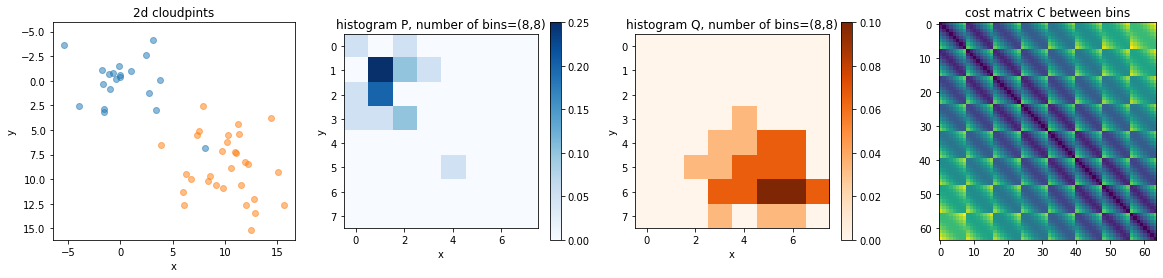

In [13]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title('2d cloudpints')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.scatter(Y[:,0], Y[:,1], alpha=0.5)
plt.ylim(max(X.max(), Y.max()) + 0.5, min(X.min(), Y.min()) - 0.5)
plt.subplot(142)
plt.title(f'histogram P, number of bins=({n2d},{n2d})')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(p.reshape(n2d, n2d), cmap='Blues')
plt.colorbar()
plt.subplot(143)
plt.title(f'histogram Q, number of bins=({n2d},{n2d})')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(q.reshape(n2d, n2d), cmap='Oranges')
plt.colorbar()
plt.subplot(144)
plt.title('cost matrix C between bins')
plt.imshow(c)
plt.show()

#iterations=675, early stopping: tol, err=2.7755575615628914e-17


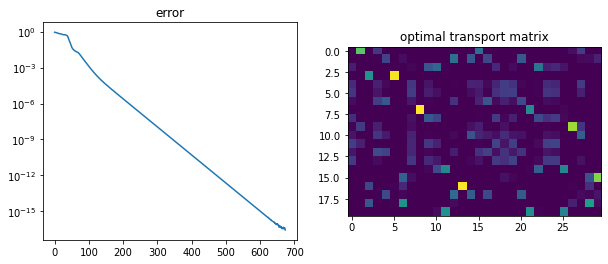

In [14]:
K, u, v = sinkhorn(X, Y, beta=0.025, max_iter=1000, eps=1e-20, tol=1e-17, patience=10)

# 3D bins

In [15]:
N, M, d = 200, 150, 3
X = np.random.normal(0, 3, (N, d))
Y = np.random.normal(10, 3, (M, d))

n3d = 4

In [16]:
bins, p, q = binning(X, Y, n3d)
c = cdist(bins, bins)
c3d = c

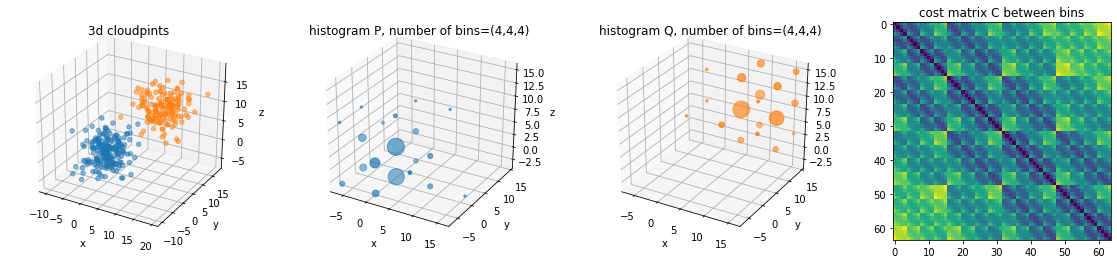

In [17]:
fig = plt.figure(figsize=(20,4), )
ax = fig.add_subplot(141, projection='3d')
ax.set_title('3d cloudpints')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=0.5)
ax.scatter(Y[:,0], Y[:,1], Y[:,2], alpha=0.5)
ax2 = fig.add_subplot(142, projection='3d')
ax2.set_title(f'histogram P, number of bins=({n3d},{n3d},{n3d})')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.scatter(bins[:,0], bins[:,1], bins[:,2], s=p.ravel() * 1000, marker='o', c='#1f77b4')
ax3 = fig.add_subplot(143, projection='3d')
ax3.set_title(f'histogram Q, number of bins=({n3d},{n3d},{n3d})')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.scatter(bins[:,0], bins[:,1], bins[:,2], s=q.ravel() * 1000, marker='o', c='#ff7f0e')
ax4 = fig.add_subplot(144)
ax4.set_title('cost matrix C between bins')
ax4.imshow(c)
plt.show()

#iterations=530, early stopping: tol, err=7.790933336231186e-17


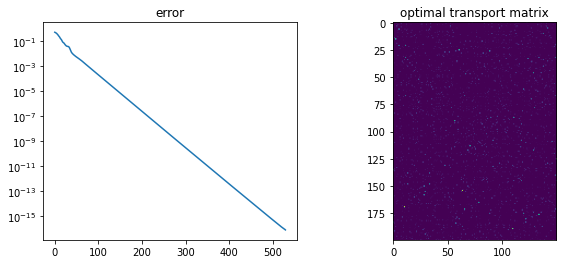

In [18]:
K, u, v = sinkhorn(X, Y, beta=0.035, max_iter=1000, eps=1e-20, tol=1e-17, patience=10)

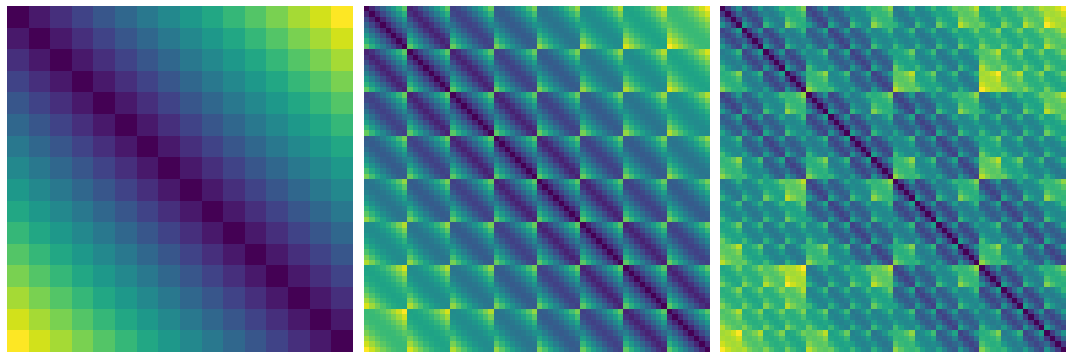

In [19]:
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.axis('off')
plt.imshow(c1d)
plt.subplot(132)
plt.axis('off')
plt.imshow(c2d)
plt.subplot(133)
plt.axis('off')
plt.imshow(c3d)
plt.tight_layout()
plt.savefig('bttb.png')

# toeplitz 1d matvec

In [20]:
blocks = c1d[0].reshape(n1d)
blocks1d = blocks

In [21]:
circ = np.concatenate([blocks, np.zeros(1), blocks[:0:-1]], -1)

In [22]:
circ.shape, c1d.shape

((32,), (16, 16))

In [23]:
x1d = np.random.rand(n1d)
x_ = np.pad(x1d, (0, n1d))

In [24]:
np.isclose(c1d.dot(x1d), np.abs(mkl_fft.ifftn((mkl_fft.fftn(circ) * mkl_fft.fftn(x_))))[:n1d].ravel()).all()

True

# toeplitz 2d matvec

In [25]:
blocks = c2d[0].reshape(n2d, n2d)
blocks2d = blocks

In [26]:
block_circ = np.concatenate([blocks,     np.zeros((n2d, 1)),     blocks[:,:0:-1]],   -1)
circ       = np.concatenate([block_circ, np.zeros((1, n2d * 2)), block_circ[:0:-1]], -2)

In [27]:
circ.shape, c2d.shape

((16, 16), (64, 64))

In [28]:
x2d = np.random.rand(c2d.shape[0])
x_ = np.pad(x2d.reshape(n2d,n2d), ((0,n2d),(0,n2d)))

In [29]:
np.isclose(c2d.dot(x2d), np.abs(mkl_fft.ifftn((mkl_fft.fftn(circ) * mkl_fft.fftn(x_))))[:n2d,:n2d].ravel()).all()

True

# toeplitz 3d matvec

In [30]:
blocks = c3d[0].reshape(n3d, n3d, n3d)
blocks3d = blocks

In [31]:
row_blocks = np.concatenate([blocks,     np.zeros((n3d, n3d, 1)),         blocks[:,:,:0:-1]],  -1)
block_circ = np.concatenate([row_blocks, np.zeros((n3d, 1, n3d * 2)),     row_blocks[:,:0:-1]], -2)
circ       = np.concatenate([block_circ, np.zeros((1, n3d * 2, n3d * 2)), block_circ[:0:-1]],   -3)

In [32]:
circ.shape, c3d.shape

((8, 8, 8), (64, 64))

In [33]:
x3d = np.random.rand(c3d.shape[0])
x_ = np.pad(x3d.reshape(n3d,n3d,n3d), ((0,n3d),(0,n3d),(0,n3d)))

In [34]:
np.isclose(c3d.dot(x3d), np.abs(mkl_fft.ifftn(mkl_fft.fftn(circ) * mkl_fft.fftn(x_)))[:n3d,:n3d,:n3d].ravel()).all()

True

## Matvec Toeplitz

In [35]:
is_pow_2 = lambda x: x == 2 ** int(np.log2(x))

class Toeplitz(object):
    '''Class for utilizing Toeplitz matrix (assume it is symmetric and has block-level no more than 3)'''
    def __init__(self, top, size=None):
        '''
        
        top: nd.array, 
                the first row of the matrix, that defines the matrix; if 'size' is None, then assume that 
                shape of the array defines the block-level structure.
        size: tuple of int or None, 
                defines block-level structure, i.e. number of dimensions equals to level of matrix,
                each size of dimension is number of blocks of each level and size of last dimension is block size.
                Any size needs to be a power of 2.
        '''
        self.top = top if size is None else top.reshape(size)
        self.size = top.shape if size is None else size
        self.dim = len(self.size)
        self.area = tuple(slice(s) for s in self.size)
        self.pad = tuple((0, s) for s in self.size)
        
        assert all([is_pow_2(s) for s in self.size]), 'sizes need to be powers of 2'
        
        self.embedding = self.make_embedding(self.top)
        self.circ_fft = mkl_fft.fftn(self.embedding)
    
    def make_embedding(self, top):
        blocks = top
        for i in range(-1, -self.dim - 1, -1):
            zeros_size = list(self.size)
            for j in range(i, 0):
                if j == i:
                    zeros_size[j] = 1
                else:
                    zeros_size[j] *= 2
            slice_ = [slice(None) for _ in range(self.dim)]
            slice_[i] = slice(None, 0, -1)
            blocks = np.concatenate([blocks, np.zeros(zeros_size), blocks[tuple(slice_)]], i)
        return blocks
        
    def matvec(self, x):
        ''' fast "matvec" multiplication '''
        if x.ndim > 1:
            if (x.shape[0] == 1 or x.shape[1] == 1):
                x = x.ravel()
            else:
                raise ValueError()
        x_fft = mkl_fft.fftn(np.pad(x.reshape(self.size), self.pad))
        
        return np.abs(mkl_fft.ifftn(self.circ_fft * x_fft)[self.area]).ravel()
    
    def full(self):
        ''' return full matrix np.exp(-C / beta)'''
        raise NotImplementedError()

In [36]:
tb_1d = Toeplitz(blocks1d)
np.isclose(tb_1d.matvec(x1d), c1d.dot(x1d)).all()

True

In [37]:
tb_2d = Toeplitz(blocks2d)
np.isclose(tb_2d.matvec(x2d), c2d.dot(x2d)).all()

True

In [38]:
tb_3d = Toeplitz(blocks3d)
np.isclose(tb_3d.matvec(x3d), c3d.dot(x3d)).all()

True

# Sinkhorn + toeplitz matvec

In [39]:
def sinkhorn_toeplitz(X, Y, bin_size, beta=0.01, max_iter=200, stop=True, eps=1e-12, tol=1e-10, patience=10, verbose=True, plot=True):
    '''
    X, Y - datapoint of two distributions
    bin_size - number of bins (equal for each dimension)
    beta - regularization parameter 
    '''
    bins, p, q = binning(X, Y, bin_size)
    size = p.shape
    p = p.ravel()
    q = q.ravel()
    top = cdist(bins[0].reshape(1,-1), bins)
    K = Toeplitz(np.exp(- top / beta), size)
    b = np.ones(np.prod(size))
    
    i = 0
    if stop:
        j = 0
        err = [10]
    while i < max_iter:
        Kb = K.matvec(b)
        a = np.divide(p, Kb)
        Ka = K.matvec(a)
        b = np.divide(q, Ka)
        
        if stop:
            g0 = b * Ka
            g1 = a * Kb

            err.append(np.linalg.norm(g0 - p) + np.linalg.norm(g1 - q))
            #########################################################
            # if good enough
            if err[-1] < eps:
                if verbose:
                    print(f'#iterations={i+1}, early stopping: eps, err={err[-1]}')
                break
            # if no improvements
            if np.abs(err[-2] - err[-1]) < tol:
                j += 1
                if j > patience:
                    if verbose:
                        print(f'#iterations={i+1}, early stopping: tol, err={err[-1]}')
                    break
            else:
                j = 0
        i +=1
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('error')
        plt.semilogy(range(len(err)-1), err[1:])
        plt.subplot(122)
        plt.title('optimal transport matrix')
        plt.imshow()
        plt.show()
    
    return K, a, b

In [40]:
N, M, d = 2000, 1500, 3
X = np.random.normal(0, 3, (N, d))
Y = np.random.normal(10, 3, (M, d))
bin_size = 16

In [41]:
%timeit sinkhorn_toeplitz(X, Y, bin_size=16, beta=1, max_iter=10, stop=False, verbose=False, plot=False)

10 loops, best of 3: 19.8 ms per loop


In [42]:
%timeit sinkhorn(X, Y, beta=1, max_iter=10, stop=False, verbose=False, plot=False)

1 loop, best of 3: 257 ms per loop


In [43]:
bin_size**3, len(X) + len(Y)

(4096, 3500)

In [44]:
236/18

13.11111111111111

In [45]:
##############################################################################################################################

# TESTS

## Time Complexities

In [46]:
datasizes = np.logspace(5, 16, 12, base=2, dtype=int)
bins_sizes = np.array([datasizes, 
                       np.repeat(np.logspace(3, 8, 6, base=2, dtype=int), 2), 
                       np.repeat(np.logspace(2,5,4, base=2, dtype=int), 3)])

In [47]:
datasizes[3:-1]

array([  256,   512,  1024,  2048,  4096,  8192, 16384, 32768])

In [48]:
bins_sizes[:,3:-1]

array([[  256,   512,  1024,  2048,  4096,  8192, 16384, 32768],
       [   16,    32,    32,    64,    64,   128,   128,   256],
       [    8,     8,     8,    16,    16,    16,    32,    32]])

In [49]:
bins_sizes[0][3:-1], bins_sizes[1][3:-1], bins_sizes[2][3:-1]

(array([  256,   512,  1024,  2048,  4096,  8192, 16384, 32768]),
 array([ 16,  32,  32,  64,  64, 128, 128, 256]),
 array([ 8,  8,  8, 16, 16, 16, 32, 32]))

In [56]:
st = np.empty((3, len(datasizes)))
stt = np.empty((3, len(datasizes)))
for d in [1, 2, 3]:
    for i in tqdm(range(len(datasizes) - 1)):
        N = datasizes[i]
        X = np.random.normal(0, 3, (N // 2, d))
        Y = np.random.normal(9, 3, (N // 2, d))
        t = %timeit -o -q -n 3 sinkhorn(X, Y, beta=1, max_iter=100, stop=False, verbose=False, plot=False)
        st[d-1,i] = t.best
        tt = %timeit -o -q -n 3 sinkhorn_toeplitz(X, Y, bin_size=bins_sizes[d-1,i], beta=1, max_iter=100, stop=False, verbose=False, plot=False)
        stt[d-1,i] = tt.best

100%|██████████| 11/11 [10:23<00:00, 56.73s/it] 


In [57]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from cycler import cycler

plt.rcParams.update({'font.size': 20, 'axes.prop_cycle':
cycler(color=['hotpink', 'violet', 'mediumpurple', 'darkcyan', 'lightseagreen', 'limegreen'])})

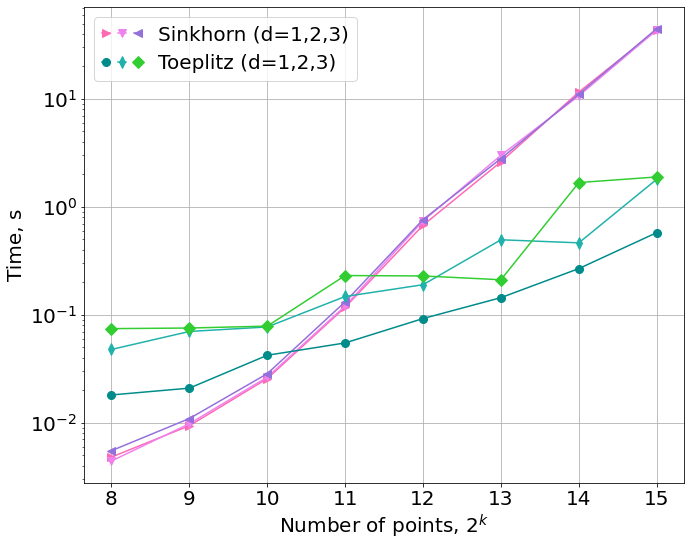

In [58]:
plt.figure(figsize=(10,8))
p1, = plt.semilogy(st[0,3:-1], marker='>', markersize=8,)
p2, = plt.semilogy(st[1,3:-1], marker='v', markersize=8,)
p3, = plt.semilogy(st[2,3:-1], marker='<', markersize=8,)

l = plt.legend([(p1, p2, p3)], ['Sinkhorn (1D/2D/3D)'], numpoints=1,
               handler_map={tuple: HandlerTuple(ndivide=None)})

p1_, = plt.semilogy(stt[0,3:-1], marker='o', markersize=8,)
p2_, = plt.semilogy(stt[1,3:-1], marker='d', markersize=8,)
p3_, = plt.semilogy(stt[2,3:-1], marker='D', markersize=8,)

plt.xticks(range(8), range(8,16))
plt.xlabel('Number of points, $2^k$')
plt.ylabel('Time, s')
l = plt.legend([(p1, p2, p3), (p1_, p2_, p3_)], ['Sinkhorn (d=1,2,3)', 'Toeplitz (d=1,2,3)'], numpoints=1,
               handler_map={tuple: HandlerTuple(ndivide=None)})

plt.grid()
plt.tight_layout()
plt.savefig('test.png')

## Quality Tests

# TODO 

- [barycentric mapping](https://papers.nips.cc/paper/6312-mapping-estimation-for-discrete-optimal-transport.pdf)

- accuracy tests

Once the probabilistic coupling $\gamma_0$ has been computed, one needs to map
the examples from $\Omega_{S}$ to $\Omega_{T}$. This mapping can be conveniently expressed with respect to the set of
examples $X_t$ as the following barycentric mapping:
$$\hat{x_i^s} = \arg\min_{x\in\Omega_{T}} \sum_{j=0}^{n_t} \gamma_0(i, j) c(x, x^t_j),$$
where $x^s_i$ is a given source sample and $\hat{x^s_i}$ is its corresponding image. When the cost function is the
squared $\ell_2$ distance, i.e. $c(x, x_0) = \|x − x_0\|_2^2$, this barycentre corresponds to a weighted average
and the sample is mapped into the convex hull of the target examples. For all source samples, this
barycentric mapping can therefore be expressed as:
$$X_S = B_{\gamma_0}(X_S) = diag(\gamma_0 1_{n_t})^{-1} \gamma_0 X_T.$$

In [54]:
# def mapping(gamma, X):
#     '''
#     gamma - optimal transport
#     X - set of source samples to map (bins)
#     '''
#     return np.linalg.pinv(np.diag(gamma.sum(1))) @ gamma @ X

### Time comparison

In [60]:
from scipy import fftpack

results = []
for i in tqdm(range(5, 15)):
    N = 2 ** i
    X = np.random.rand(N, N) # matrix K
    x = np.random.rand(2 * N) # matrix K as vector
    y = np.random.rand(2 * N) # u (512) padded with zeros to (1024)
    fftx = np.fft.fft(x)
    
    tr = %timeit -q -o np.fft.ifft(fftx * np.fft.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o sp.fft.ifft(fftx * sp.fft.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o fftpack.ifft(fftx * fftpack.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o mkl_fft.ifft(fftx * mkl_fft.fft(y))
    results.append(tr.best)
    
    tr = %timeit -q -o X.dot(y[:N])
    results.append(tr.best)

100%|██████████| 10/10 [03:04<00:00, 18.44s/it]


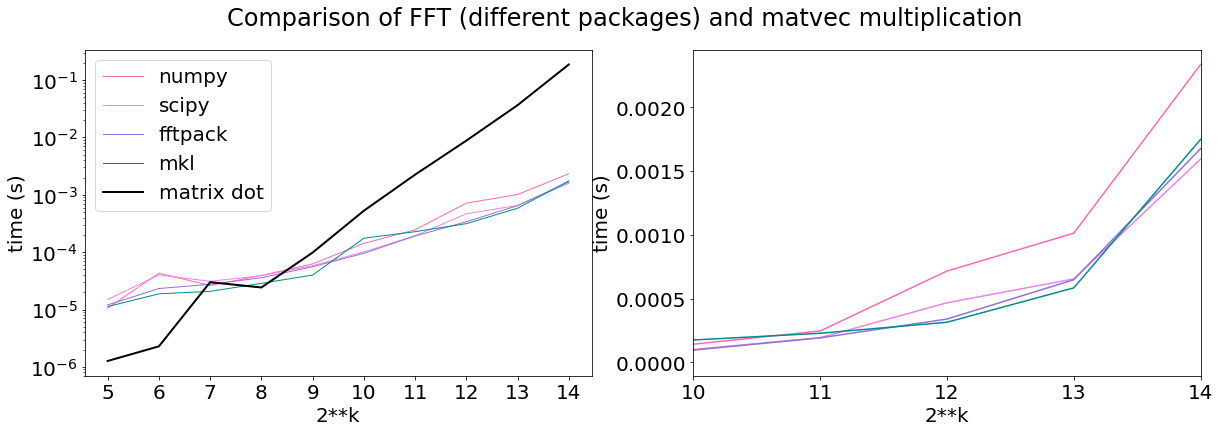

In [66]:
plt.figure(figsize=(20,6))
plt.suptitle('Comparison of FFT (different packages) and matvec multiplication')

plt.subplot(121)
plt.xlabel('2**k')
plt.ylabel('time (s)')
plt.xticks(range(10), range(5, 15))
plt.semilogy(results[0::5], linewidth=1, label='numpy')
plt.semilogy(results[1::5], linewidth=1, label='scipy')
plt.semilogy(results[2::5], linewidth=1, label='fftpack')
plt.semilogy(results[3::5], linewidth=1, label='mkl')
plt.semilogy(results[4::5], linewidth=2, c='k', label='matrix dot')
plt.legend()

plt.subplot(122)
plt.xlabel('2**k')
plt.ylabel('time (s)')
plt.xticks(range(10), range(5, 15))
plt.xlim(5, 9)
plt.plot(results[0::5])
plt.plot(results[1::5])
plt.plot(results[2::5])
plt.plot(results[3::5])
plt.show()